In [1]:
##IMPORT
from fit_all_act import PINN_multi
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
from utilities import xavier_init_routine, xavier_init_routine
from torch import nn


Bad key "text.kerning_factor" on line 4 in
C:\Users\thiba\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Set training parameters

In [5]:
#####PARAMETERS#####
#plotting
PLOT = 1

#Optimizer
MAX_ITER_LBFGS = 50000
LINESEARCH = "strong_wolfe" #"strong_wolfe" or None

#ION Channel properties
E_K = torch.tensor([-96.2], dtype = torch.float64)
G_K = torch.tensor([0.1], dtype = torch.float64)

#Model
NN_DEPTH = 15
NN_BREADTH = 20

#Training
ADAM_IT = 10000
WHOLE_DATA = False
DEVICE = "cpu"
LINE_SH = "strong_wolfe"

if not WHOLE_DATA:
    N_T = 2000 #Training set size

In [6]:
###TRAINING DATA

#Build layer list
layers = [2] #nb of inputs
for i in range(NN_DEPTH):  # nb of layers
    layers.append(NN_BREADTH)
layers.append(1) #output size

#import  data
PATH = './experimental_data/Kv1.2/Exp/Kv1.2_2505_rep2_Current.txt'
data = pd.read_csv(PATH, header=None, delim_whitespace=True)
t = data[0].to_numpy()
Ik = data.iloc[:, 1:]


PATH_act = './experimental_data/Kv1.2/Exp/Kv1.2_2505_rep2_Stimulus.txt'
v_act = pd.read_csv(PATH_act, header=None, delim_whitespace=True).to_numpy().squeeze()
v_train = v_act


# Domain bounds
lb = np.asarray([t.min(0), v_act.min(-1)])
ub = np.asarray([t.max(0), v_act.max(-1)])

# Train


In [7]:
############ TRAINING #############

if WHOLE_DATA:
    # use all the data
    t_train = t
    Ik_df = Ik

else:
    idx = np.arange(11)  # make sure rise is in training data
    idx = np.sort(np.concatenate((idx, np.random.choice(t.shape[0], N_T, replace=False))))
    t_train = t[idx]
    Ik_df = Ik.iloc[idx, :]

# Build model
model = PINN_multi(t_train, v_train, Ik_df.to_numpy(), layers, lb, ub, line_sh = LINE_SH, max_iter_lbfgs=MAX_ITER_LBFGS, device = DEVICE)
model.apply(xavier_init_routine)  # initialize nn

# TRAIN
model.train(ADAM_IT)

It: 0, Loss: 1.358e+01
Loss: 2.861e+00
Loss: 2.448e+00
Loss: 2.272e+00
Loss: 2.059e+00
Loss: 1.677e+00
Loss: 1.605e+00
Loss: 1.596e+00
Loss: 1.591e+00
Loss: 1.579e+00
Loss: 1.570e+00
Loss: 1.552e+00
Loss: 1.526e+00
Loss: 1.495e+00
Loss: 1.463e+00
Loss: 1.432e+00
Loss: 1.364e+00
Loss: 1.626e+00
Loss: 1.253e+00
Loss: 1.154e+00
Loss: 1.142e+00
Loss: 1.115e+00
Loss: 1.100e+00
Loss: 1.080e+00
Loss: 1.065e+00
Loss: 1.051e+00
Loss: 1.024e+00
Loss: 9.919e-01
Loss: 9.690e-01
Loss: 9.573e-01
Loss: 9.322e-01
Loss: 9.261e-01
Loss: 9.203e-01
Loss: 9.154e-01
Loss: 9.134e-01
Loss: 9.089e-01
Loss: 9.021e-01
Loss: 8.928e-01
Loss: 8.799e-01
Loss: 8.509e-01
Loss: 8.549e-01
Loss: 8.298e-01
Loss: 8.000e-01
Loss: 7.199e-01
Loss: 1.633e+00
Loss: 6.874e-01
Loss: 6.687e-01
Loss: 5.399e-01
Loss: 5.876e-01
Loss: 4.493e-01
Loss: 3.761e-01
Loss: 3.543e-01
Loss: 3.495e-01
Loss: 2.897e-01
Loss: 2.522e-01
Loss: 2.132e-01
Loss: 1.715e-01
training over


# Plot results

In [11]:
#utility fucntion for plotting
def lighten_color(color, amount=0.5):
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

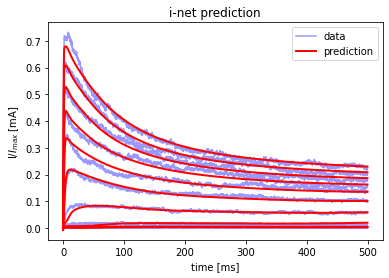

In [13]:
#PREDICTIONS

#CONSTRUCT INPUT DATA for prediction
t_tens = torch.tensor(t, dtype=torch.float64, device = "cuda").unsqueeze(-1)
v_tens = torch.tensor(v_train, dtype=torch.float64, device = "cuda").unsqueeze(-1)
_, _, Xin = model.construct_input(t_tens, v_tens)

u_pred = model.predict(Xin)
u_pred = ((u_pred + 1)*(model.I.max().cpu().detach().numpy() - model.I.min().cpu().detach().numpy())/2+model.I.min().cpu().detach().numpy())



plt.title("i-net prediction")
plt.xlabel("time [ms]")
plt.ylabel(r"I/$I_{max}$ [mA]")
plt.plot(t, Ik.to_numpy()[:, :-1], color=lighten_color('b', 0.4))
plt.plot(t, Ik.to_numpy()[:, -1], label = "data", color=lighten_color('b', 0.4))

plt.plot(t, np.squeeze(u_pred)[:, :-1], 'r', linewidth = 2.0)
plt.plot(t, np.squeeze(u_pred)[:, -1], 'r', label = "prediction", linewidth = 2.0)
plt.legend()
plt.savefig("plots/net_pred_multi_exp.svg")

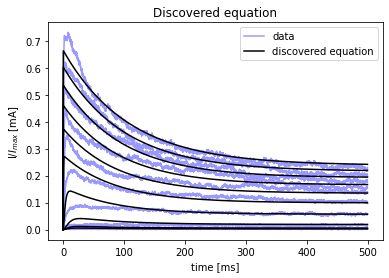

In [14]:
from scipy.integrate import odeint
def func(p, t, p_inf, p_tau):
    dp = (p_inf - p) / p_tau
    return dp

#Ik = Ik.to_numpy()
m_reg = odeint(func, np.zeros(10), t, args = (model.m_inf.cpu().detach().numpy(), model.m_tau.cpu().detach().numpy()*5))
h_reg = odeint(func, np.ones(10), t, args = (model.h_inf.cpu().detach().numpy(), model.h_tau.cpu().detach().numpy()*500))
I_reg =  0.1*m_reg*m_reg*h_reg*(v_act - (-96.2))


plt.title("Discovered equation")
plt.plot(t, Ik.to_numpy()[:, :-1], color=lighten_color('b', 0.4))
plt.plot(t, Ik.to_numpy()[:, -1], label = "data",color=lighten_color('b', 0.4))
plt.plot(t, I_reg[:, :-1], 'k')
plt.plot(t, I_reg[:, -1], 'k', label = "discovered equation")

plt.xlabel("time [ms]")
plt.ylabel(r"I/$I_{max}$ [mA]")
plt.legend()
plt.savefig("plots/eq_pred_multi_exp.svg")

# MSEs

In [17]:

loss = nn.MSELoss()
netMSE = loss(torch.Tensor(np.squeeze(u_pred)), torch.Tensor(Ik.to_numpy()))
print('%.10f' %netMSE)

0.0000764472


In [18]:
eqMSE = loss(torch.Tensor(I_reg.squeeze()), torch.Tensor(Ik.to_numpy().squeeze()))
print('%.10f' %eqMSE)

0.0003282870
